In [7]:
# Parkinsonics Regression Modeling - started 11.13.19

In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
import io, os
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from sklearn.linear_model import LinearRegression

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
%%capture
%run Parkinsonics_EDA_V4.0.ipynb

# Import all the variables and sliced dataframes from EDA notebook
# (Comment last so that capture will work)

In [3]:
# Load randomization patient ID list
IDdf=pd.read_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Parkinsonics_RandID_ List_DID.xlsx')

IDdf=IDdf[:-5]

In [9]:
masterdf.shape

(26, 673)

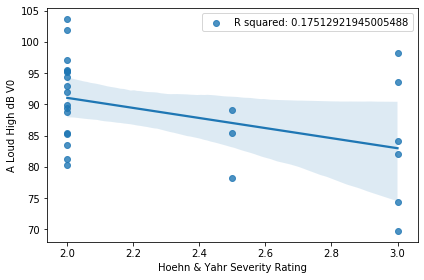

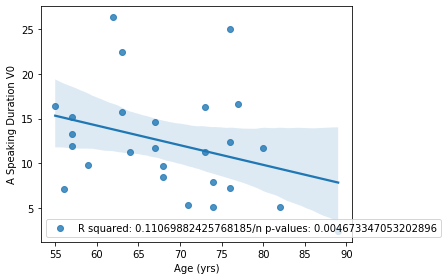

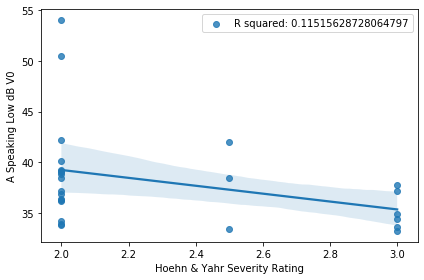

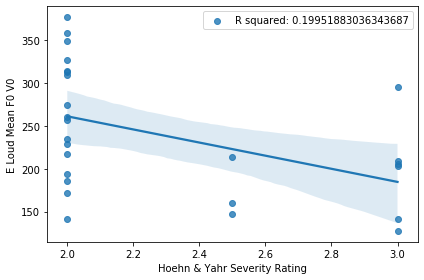

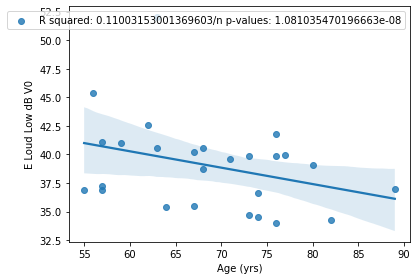

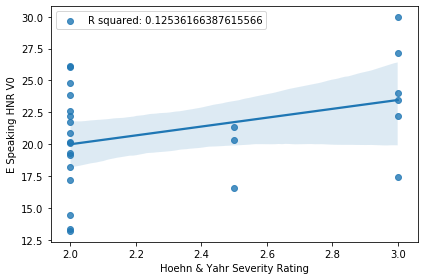

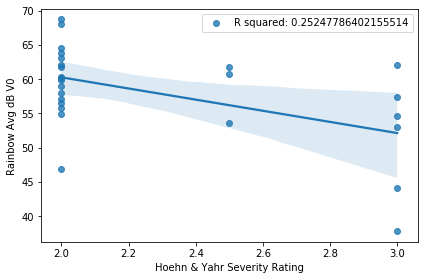

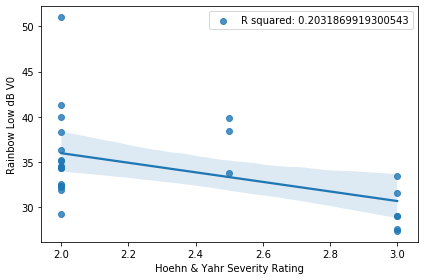

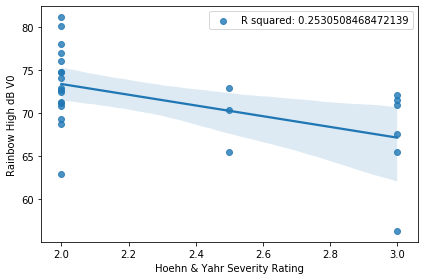

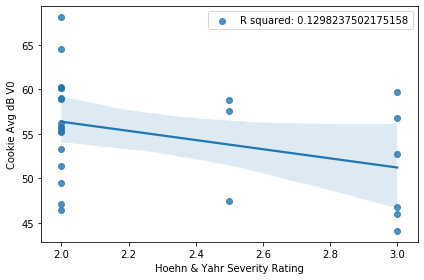

In [4]:
# SIMPLE LINEAR REGRESSIONS - Part 1
# Indep vars are HY/Age, outcome is baseline voice params
# Slice IDdf to obtain just regressors values, then reshape to get 2D array
hyage_reg=pd.DataFrame(columns=['Variable', 'p: Age', 'p: H&Y', 'R2: Age', 'R2: H&Y'])

# Loop thru dataframes of all variables so can regress against all vars
for meandf in meandflist:
    varname=meandf.columns[0]
    y=meandf[varname+' V0']
    x=meandf['ID']
    IDtemp=IDdf.copy()
    
    # Drop nan values in the baseline params (y)
    # Drop patients who have those nan values (IDtemp)
    for i in y.index:
        if math.isnan(y[i]):
            y=y.drop(labels=[i])
            strid=str(x[i])
            if len(strid)==5:
                strid='0'+strid
            for i in IDdf['ID'].index:
                if IDdf['ID'][i]==strid:
                    IDtemp.drop(labels=[i], inplace=True)
                  
    ID_age=IDtemp['Age'].values.reshape(-1, 1)
    ID_hy=IDtemp['Hoehn & Yahr'].values.reshape(-1, 1)
    X_age=sm.add_constant(ID_age)
    X_hy=sm.add_constant(ID_hy)
           
    tempdf=pd.DataFrame(columns=['Variable', 'p: Age', 'p: H&Y', 'R2: Age', 'R2: H&Y'], index=[str(count)])
    
    # Create regression model, fit to age and baseline values for 1 var
    model_age=sm.OLS(y.astype(float), X_age, missing='drop')
    model_hy=sm.OLS(y.astype(float), X_hy, missing='drop')
    fit_age=model_age.fit()
    fit_hy=model_hy.fit()
    
    #agest, agedata, agess2=summary_table(fit_age, alpha=0.05)
    #hyst, hydata, hyss2=summary_table(fit_hy, alpha=0.05)
    
    #agefitted=agedata[:,2]
    #hyfitted=hydata[:,2]
    
    # Plot figs only if regression model shows significant pval and R2>0.1 (since everything is low)
    if fit_age.rsquared>0.1 and fit_age.pvalues[0]<0.05:
        plt.figure()
        ax=sns.regplot(x=ID_age, y=y, label='R squared: '+str(fit_age.rsquared)
                       +'/n p-values: '+str(fit_age.pvalues[0]))
        ax.legend()
        ax.set(xlabel='Age (yrs)')
        plt.tight_layout()
        plt.show()
    if fit_hy.rsquared>0.1 and fit_hy.pvalues[0]<0.05:
        plt.figure()
        ax=sns.regplot(x=ID_hy, y=y, label='R squared: '+str(fit_hy.rsquared))
        ax.legend()
        ax.set(xlabel='Hoehn & Yahr Severity Rating')
        plt.tight_layout()
        plt.show()
    
    # Write stuff to tempdf, append to overall df
    tempdf['Variable']=varname
    tempdf['p: Age']=fit_age.pvalues[0]
    tempdf['p: H&Y']=fit_hy.pvalues[0]
    tempdf['R2: Age']=fit_age.rsquared
    tempdf['R2: H&Y']=fit_hy.rsquared
    hyage_reg=pd.concat([hyage_reg, tempdf], sort=False)
    
    
hyage_reg=pd.concat([hyage_reg], axis=1)


In [23]:
sh_age_df=smt.multipletests(hyage_reg.iloc[:, 1], alpha=0.05, method='sh')
sh_hy_df=smt.multipletests(hyage_reg.iloc[:, 2], alpha=0.05, method='sh')
hyage_reg['p: Age']=sh_age_df[1]
hyage_reg['p: H&Y']=sh_hy_df[1]
cols=['Variable', 'p: Age', 'p: H&Y', 'R2: Age', 'R2: H&Y']
hyage_reg=hyage_reg.loc[:,cols]

In [25]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
hyage_reg.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Results_Simple_LinReg_AgeHY_2.xlsx')

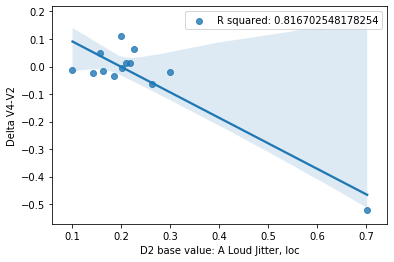

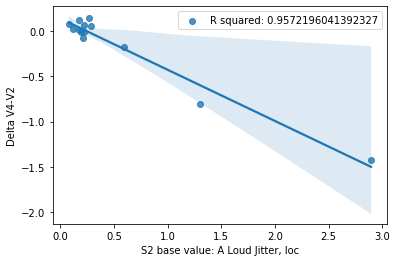

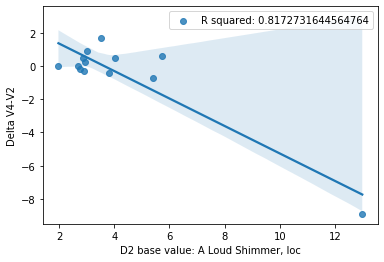

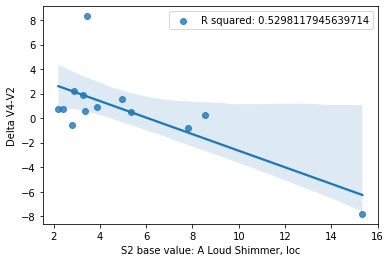

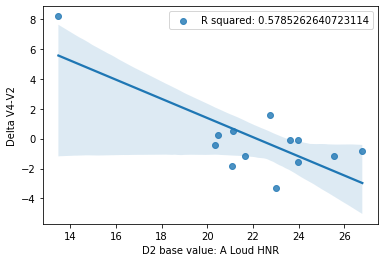

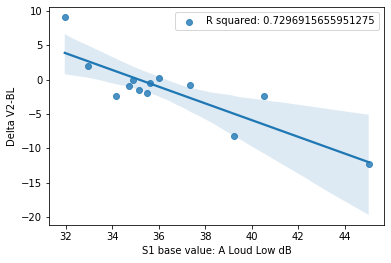

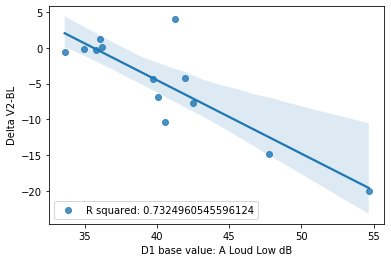

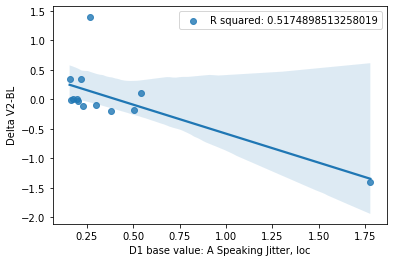

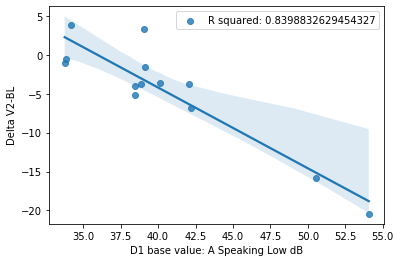

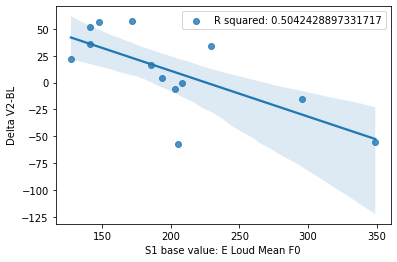

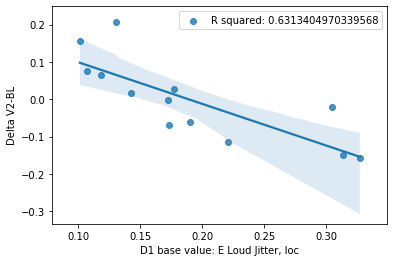

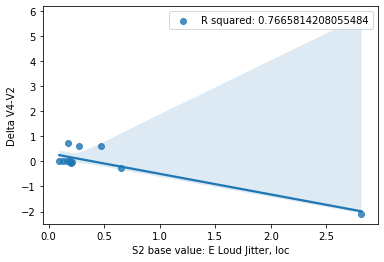

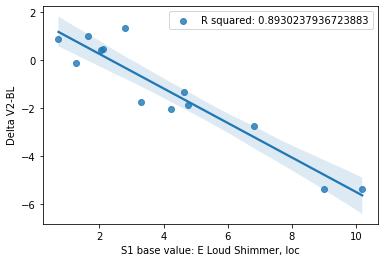

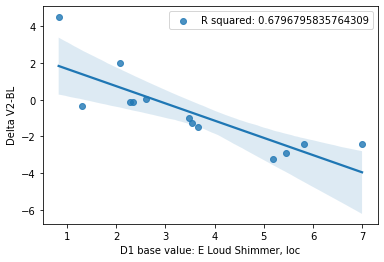

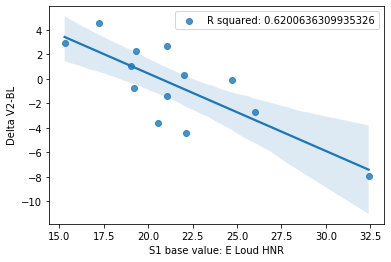

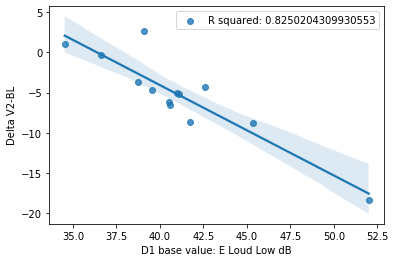

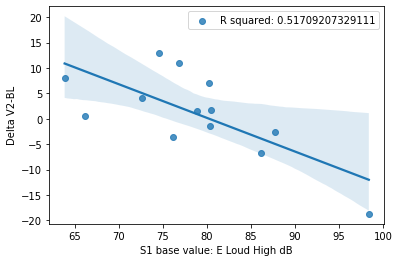

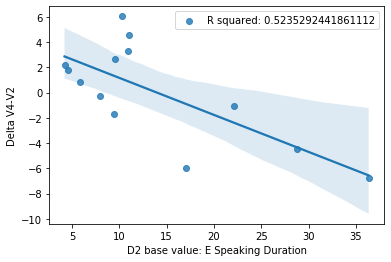

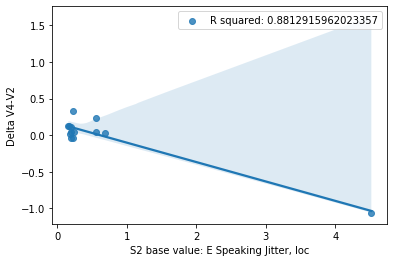

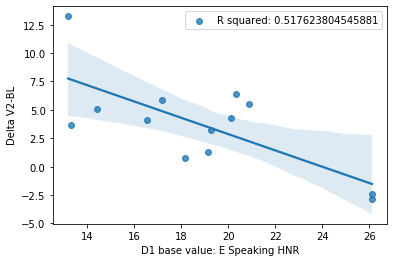

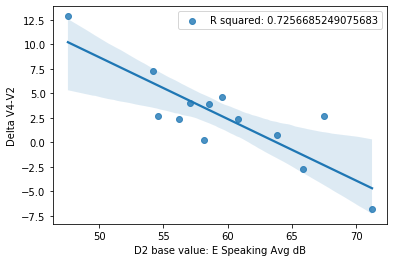

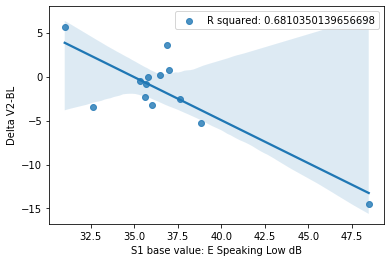

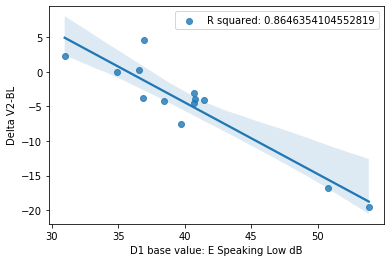

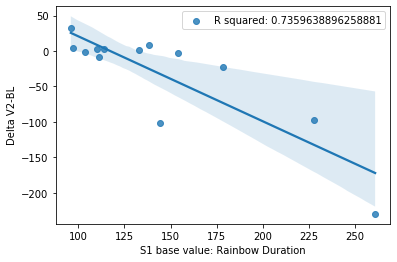

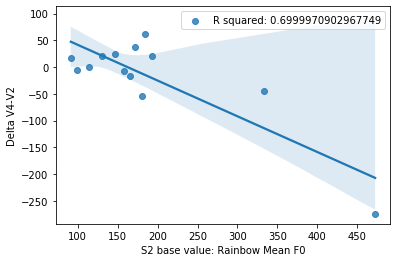

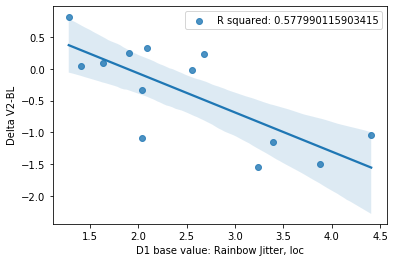

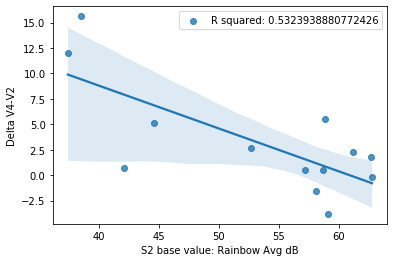

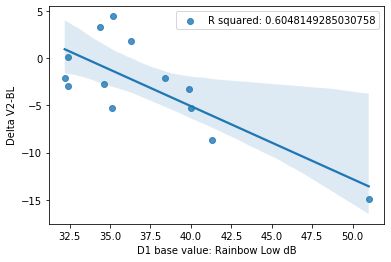

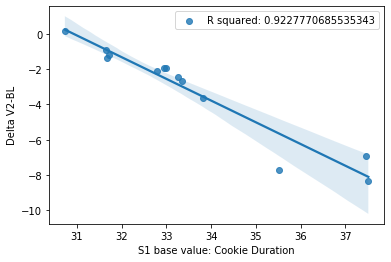

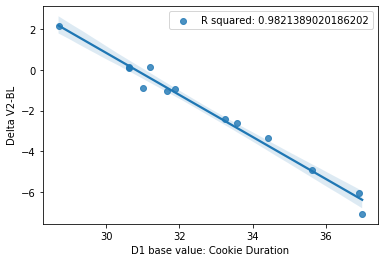

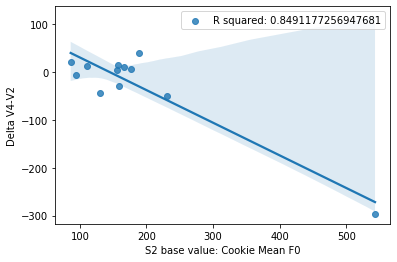

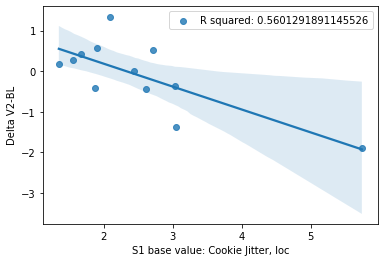

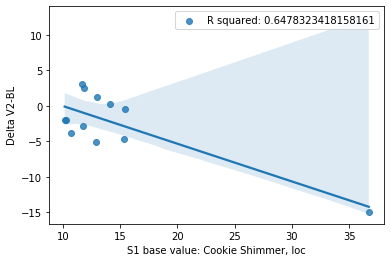

In [11]:
# SIMPLE LINEAR REGRESSIONS - Part 2
# Regressors are baseline values, outcome is change in values over S1/D2.
# Slice each meandf to obtain just regressors values, then reshape to get 2D array

bldelta_reg=pd.DataFrame(columns=['Variable', 'R2: S1', 'R2: D2', 'R2: D1', 'R2: S2', 
                                  'p: S1', 'p: D2', 'p: D1', 'p: S2'])

for meandf in meandflist:
    varname=meandf.columns[0]
    tempmean=meandf.copy()
    for i in meandf.index:
        if math.isnan(meandf[varname+' V0'][i]) or math.isnan(meandf[varname+' V2'][i]):
            tempmean.drop(labels=[i], inplace=True)
            
    tempdf=pd.DataFrame(columns=['Variable', 'R2: S1', 'R2: D2', 'R2: D1', 'R2: S2', 
                                  'p: S1', 'p: D2', 'p: D1', 'p: S2'], index=[str(count)])
    
    # Slice to obtain regressors, reshape to get 2D array
    S1_base=tempmean.loc[tempmean['First Intervention']=='S'][varname+' V0'].values.reshape(-1, 1).astype(float)
    D1_base=tempmean.loc[tempmean['First Intervention']=='D'][varname+' V0'].values.reshape(-1, 1).astype(float)
    D2_base=tempmean.loc[tempmean['First Intervention']=='D'][varname+' V2'].values.reshape(-1, 1).astype(float)
    S2_base=tempmean.loc[tempmean['First Intervention']=='S'][varname+' V2'].values.reshape(-1, 1).astype(float)
    X_S1=sm.add_constant(S1_base)
    X_D1=sm.add_constant(D1_base)
    X_D2=sm.add_constant(D2_base)
    X_S2=sm.add_constant(S2_base)
    
    # Slice to obtain outcome vars, no need to reshape
    S1_delta=tempmean.loc[tempmean['First Intervention']=='S']['Delta V2-BL'].astype(float)
    D1_delta=tempmean.loc[tempmean['First Intervention']=='D']['Delta V2-BL'].astype(float)
    D2_delta=tempmean.loc[tempmean['First Intervention']=='D']['Delta V4-V2'].astype(float)
    S2_delta=tempmean.loc[tempmean['First Intervention']=='S']['Delta V4-V2'].astype(float)
    
    # Create regression model, fit to baseline values
    model_S1=sm.OLS(S1_delta, X_S1, missing='drop')
    model_D1=sm.OLS(D1_delta, X_D1, missing='drop')
    model_D2=sm.OLS(D2_delta, X_D2, missing='drop')
    model_S2=sm.OLS(S2_delta, X_S2, missing='drop')
    fit_S1=model_S1.fit()
    fit_D1=model_D1.fit()
    fit_D2=model_D2.fit()
    fit_S2=model_S2.fit()
    
    S1st, S1data, S1ss2=summary_table(fit_S1, alpha=0.05)
    D1st, D1data, D1ss2=summary_table(fit_D1, alpha=0.05)
    D2st, D2data, D2ss2=summary_table(fit_D2, alpha=0.05)
    S2st, S2data, S2ss2=summary_table(fit_S2, alpha=0.05)
    
    S1fitted=S1data[:,2]
    D1fitted=D1data[:,2]
    D2fitted=D2data[:,2]
    S2fitted=S2data[:,2]
    
    # Plot figs only if regression model shows significant pval and R2>0.1 (since everything is low)
    if fit_S1.rsquared>0.5 and fit_S1.pvalues[0]<0.05:
        plt.figure()
        ax=sns.regplot(x=S1_base, y=S1_delta, label='R squared: '+str(fit_S1.rsquared))
        ax.legend()
        ax.set(xlabel='S1 base value: '+varname)
        plt.show()
    if fit_D2.rsquared>0.5 and fit_D2.pvalues[0]<0.05:
        plt.figure()
        ax=sns.regplot(x=D2_base, y=D2_delta, label='R squared: '+str(fit_D2.rsquared))
        ax.legend()
        ax.set(xlabel='D2 base value: '+varname)
        plt.show()
    if fit_D1.rsquared>0.5 and fit_D1.pvalues[0]<0.05:
        plt.figure()
        ax=sns.regplot(x=D1_base, y=D1_delta, label='R squared: '+str(fit_D1.rsquared))
        ax.legend()
        ax.set(xlabel='D1 base value: '+varname)
        plt.show()
    if fit_S2.rsquared>0.5 and fit_S2.pvalues[0]<0.05:
        plt.figure()
        ax=sns.regplot(x=S2_base, y=S2_delta, label='R squared: '+str(fit_S2.rsquared))
        ax.legend()
        ax.set(xlabel='S2 base value: '+varname)
        plt.show()
    
    # Write stuff to tempdf, append to overall df
    tempdf['Variable']=varname
    tempdf['R2: S1']=fit_S1.rsquared
    tempdf['R2: D1']=fit_D1.rsquared
    tempdf['R2: D2']=fit_D2.rsquared
    tempdf['R2: S2']=fit_S2.rsquared                         
    tempdf['p: S1']=fit_S1.pvalues[0]
    tempdf['p: D1']=fit_D1.pvalues[0]
    tempdf['p: D2']=fit_D2.pvalues[0]
    tempdf['p: S2']=fit_S2.pvalues[0]                         
    bldelta_reg=pd.concat([bldelta_reg, tempdf], sort=False)
    
bldelta_reg=pd.concat([bldelta_reg], axis=1)  

In [6]:
sh_S1bl_df=smt.multipletests(bldelta_reg.iloc[:, 5], alpha=0.05, method='sh')
sh_D2bl_df=smt.multipletests(bldelta_reg.iloc[:, 6], alpha=0.05, method='sh')
sh_D1bl_df=smt.multipletests(bldelta_reg.iloc[:, 7], alpha=0.05, method='sh')
sh_S2bl_df=smt.multipletests(bldelta_reg.iloc[:, 8], alpha=0.05, method='sh')

bldelta_reg['p: S1']=sh_S1bl_df[1]
bldelta_reg['p: D2']=sh_D2bl_df[1]
bldelta_reg['p: D1']=sh_D1bl_df[1]
bldelta_reg['p: S2']=sh_S2bl_df[1]
cols=['Variable', 'p: S1', 'p: D2', 'p: D1', 'p: S2', 'R2: S1', 'R2: D2', 'R2: D1', 'R2: S2']
bldelta_reg=bldelta_reg.loc[:,cols]

In [21]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
bldelta_reg.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Results_Simple_LinReg_Baseline_S1D2_2.xlsx')

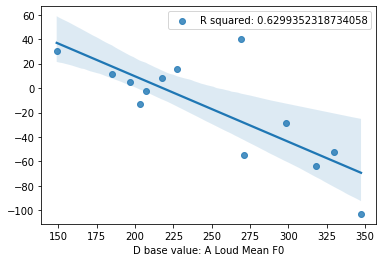

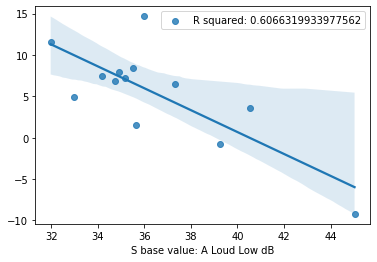

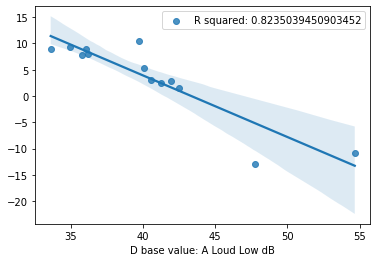

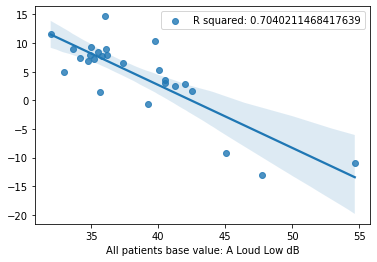

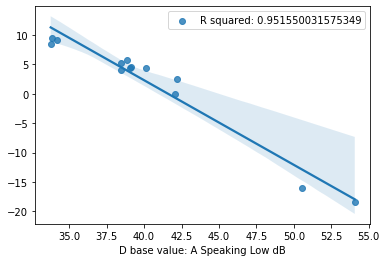

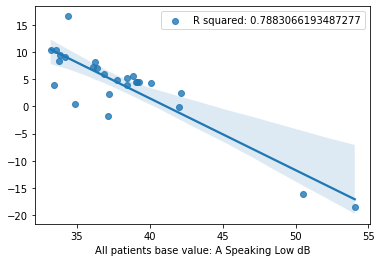

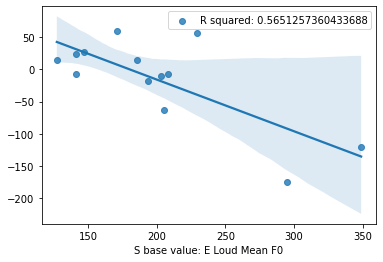

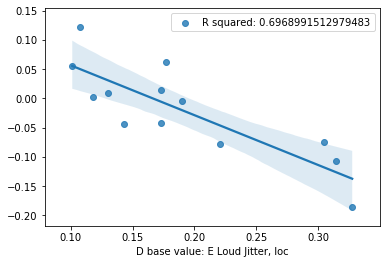

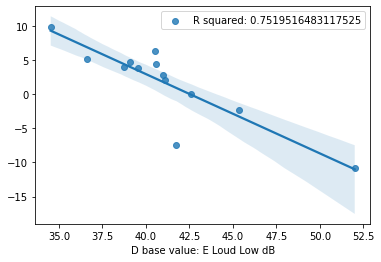

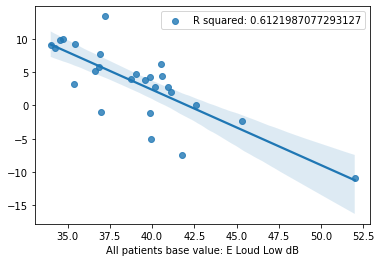

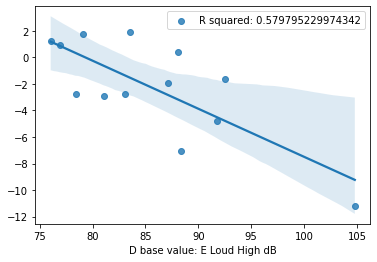

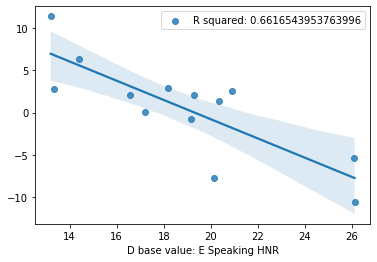

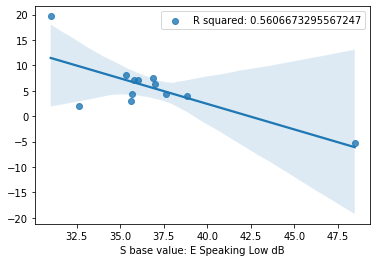

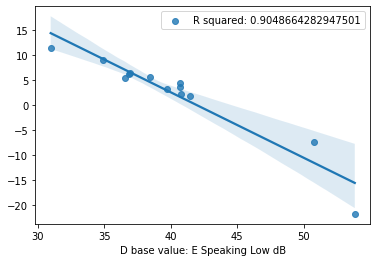

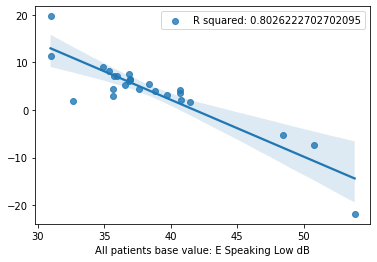

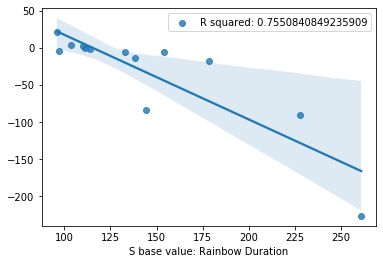

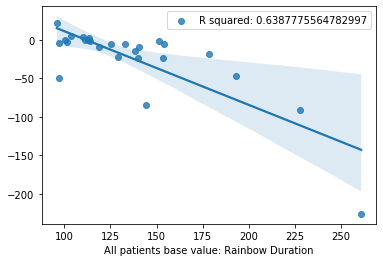

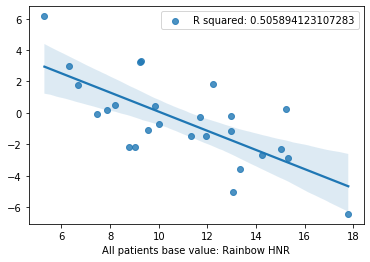

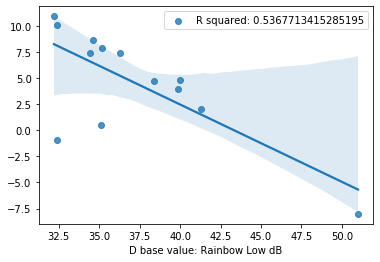

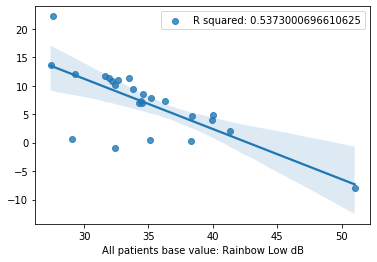

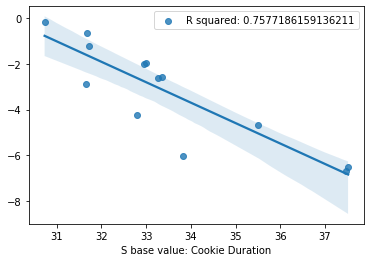

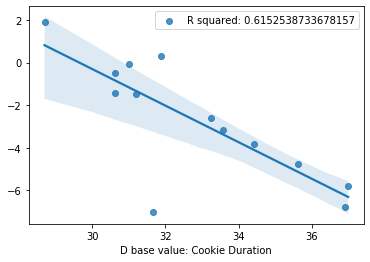

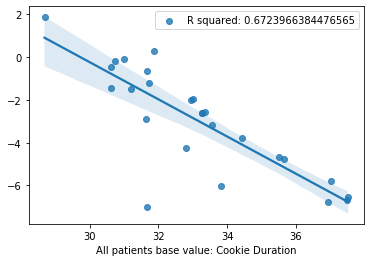

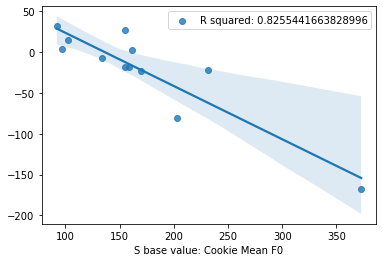

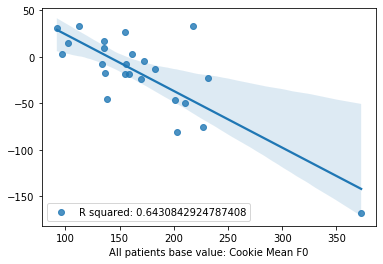

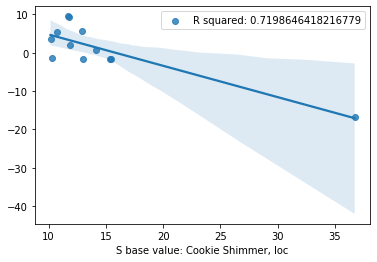

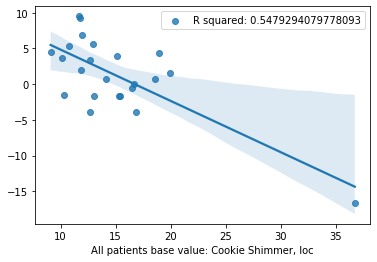

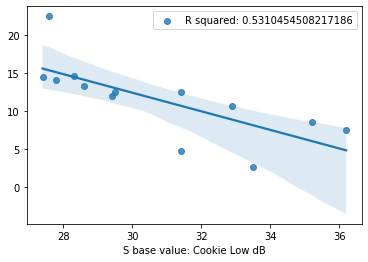

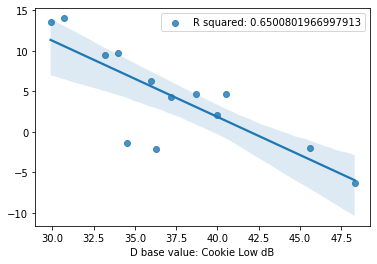

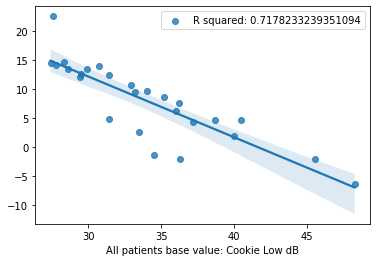

In [42]:
# SIMPLE LINEAR REGRESSIONS - Part 2.5
# Regressors are baseline values, outcome is change in values over entire course of study, sep by S and D groups.
# Slice each meandf to obtain just regressors values, then reshape to get 2D array

bldelta_ITT_reg=pd.DataFrame(columns=['Variable', 'R2: S', 'R2: D', 'R2: all',
                                  'p: S', 'p: D', 'p: all'])

for meandf in meandflist:
    varname=meandf.columns[0]
    tempmean=meandf.copy()
    for i in meandf.index:
        if math.isnan(meandf[varname+' V0'][i]) or math.isnan(meandf[varname+' V2'][i]):
            tempmean.drop(labels=[i], inplace=True)
            
    tempdf=pd.DataFrame(columns=['Variable', 'R2: S', 'R2: D', 'R2: all', 
                                 'p: S', 'p: D', 'p: all'], index=[str(count)])
    
    # Slice to obtain regressors, reshape to get 2D array
    S_base=tempmean.loc[tempmean['First Intervention']=='S'][varname+' V0'].values.reshape(-1, 1).astype(float)
    D_base=tempmean.loc[tempmean['First Intervention']=='D'][varname+' V0'].values.reshape(-1, 1).astype(float)
    all_base=tempmean[varname+' V0'].values.reshape(-1, 1).astype(float)
    
    S_end=tempmean.loc[tempmean['First Intervention']=='S'][varname+' V5'].values.reshape(-1, 1).astype(float)
    D_end=tempmean.loc[tempmean['First Intervention']=='D'][varname+' V5'].values.reshape(-1, 1).astype(float)
    all_end=tempmean[varname+' V5'].values.reshape(-1,1).astype(float)
    
    X_S=sm.add_constant(S_base)
    X_D=sm.add_constant(D_base)
    X_all=sm.add_constant(all_base)
    
    # Slice to obtain outcome vars, no need to reshape
    S_delta=S_end-S_base
    D_delta=D_end-D_base
    all_delta=all_end-all_base
    
    # Create regression model, fit to baseline values
    model_S=sm.OLS(S_delta, X_S, missing='drop')
    model_D=sm.OLS(D_delta, X_D, missing='drop')
    model_all=sm.OLS(all_delta, X_all, missing='drop')
    
    fit_S=model_S.fit()
    fit_D=model_D.fit()
    fit_all=model_all.fit()
    
    Sst, Sdata, Sss2=summary_table(fit_S, alpha=0.05)
    Dst, Ddata, Dss2=summary_table(fit_D, alpha=0.05)
    allst, alldata, allss2=summary_table(fit_all, alpha=0.05)
    
    Sfitted=Sdata[:,2]
    Dfitted=Ddata[:,2]
    allfitted=alldata[:,2]
    
    # Plot figs only if regression model shows significant pval and R2>0.1 (since everything is low)
    if fit_S.rsquared>0.5 and fit_S.pvalues[0]<0.05:
        plt.figure()
        ax=sns.regplot(x=S_base, y=S_delta, label='R squared: '+str(fit_S.rsquared))
        ax.legend()
        ax.set(xlabel='S base value: '+varname)
        plt.show()
    if fit_D.rsquared>0.5 and fit_D.pvalues[0]<0.05:
        plt.figure()
        ax=sns.regplot(x=D_base, y=D_delta, label='R squared: '+str(fit_D.rsquared))
        ax.legend()
        ax.set(xlabel='D base value: '+varname)
        plt.show()
    if fit_all.rsquared>0.5 and fit_all.pvalues[0]<0.05:
        plt.figure()
        ax=sns.regplot(x=all_base, y=all_delta, label='R squared: '+str(fit_all.rsquared))
        ax.legend()
        ax.set(xlabel='All patients base value: '+varname)
        plt.show()
    
    # Write stuff to tempdf, append to overall df
    tempdf['Variable']=varname
    tempdf['R2: S']=fit_S.rsquared
    tempdf['R2: D']=fit_D.rsquared
    tempdf['R2: all']=fit_all.rsquared
    tempdf['p: S']=fit_S.pvalues[0]
    tempdf['p: D']=fit_D.pvalues[0]
    tempdf['p: all']=fit_all.pvalues[0]                         
    bldelta_ITT_reg=pd.concat([bldelta_ITT_reg, tempdf], sort=False)
    
bldelta_ITT_reg=pd.concat([bldelta_ITT_reg], axis=1)  

In [49]:
sh_Sbl_df=smt.multipletests(bldelta_ITT_reg.iloc[:, 4], alpha=0.05, method='sh')
sh_Dbl_df=smt.multipletests(bldelta_ITT_reg.iloc[:, 5], alpha=0.05, method='sh')
sh_allbl_df=smt.multipletests(bldelta_ITT_reg.iloc[:, 6], alpha=0.05, method='sh')


bldelta_ITT_reg['p: S']=sh_Sbl_df[1]
bldelta_ITT_reg['p: D']=sh_Dbl_df[1]
bldelta_ITT_reg['p: all']=sh_allbl_df[1]
cols=['Variable', 'p: S', 'p: D', 'p: all', 'R2: S', 'R2: D', 'R2: all']
bldelta_ITT_reg=bldelta_ITT_reg.loc[:,cols]

In [51]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
bldelta_ITT_reg.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Results_Simple_LinReg_Baseline_ITT.xlsx')

In [5]:
# SIMPLE LINEAR REGRESSIONS - Part 3
# Regressors are age, outcome is change in values over S1/D2.
# Slice each meandf to obtain just regressors values, then reshape to get 2D array

agedelta_reg=pd.DataFrame(columns=['Variable', 'p: S1', 'p: D2', 'p: D1', 'p: S2',
                                   'R2: S1', 'R2: D2', 'R2: D1', 'R2: S2', 'R: S1', 'R: D2', 'R: D1', 'R: S2'])

for meandf in meandflist:
    varname=meandf.columns[0]
    tempmean_s1d2=meandf.copy()
    tempmean_s2d1=meandf.copy()
    x=meandf['ID']
    IDtemp_s1d2=IDdf.copy().loc[IDdf['First Intervention']=='S']
    IDtemp_s2d1=IDdf.copy().loc[IDdf['First Intervention']=='D']
    for i in meandf.loc[meandf['First Intervention']=='S'].index:
        if math.isnan(meandf.loc[meandf['First Intervention']=='S']['Delta V2-BL'][i]) or math.isnan(meandf.loc[meandf['First Intervention']=='S']['Delta V4-V2'][i]):
            tempmean_s1d2.drop(labels=[i], inplace=True)
            strid=str(x[i])
            if len(strid)==5:
                strid='0'+strid
            for j in IDtemp_s1d2['ID'].index:
                if IDtemp_s1d2['ID'][j]==strid:
                    IDtemp_s1d2.drop(labels=[j], inplace=True)
    for i in meandf.loc[meandf['First Intervention']=='D'].index:
        if math.isnan(meandf.loc[meandf['First Intervention']=='D']['Delta V2-BL'][i]) or math.isnan(meandf.loc[meandf['First Intervention']=='D']['Delta V4-V2'][i]):
            tempmean_s2d1.drop(labels=[i], inplace=True)
            strid=str(x[i])
            if len(strid)==5:
                strid='0'+strid
            for j in IDtemp_s2d1['ID'].index:
                if IDtemp_s2d1['ID'][j]==strid:
                    IDtemp_s2d1.drop(labels=[j], inplace=True)
            
    tempdf=pd.DataFrame(columns=['Variable', 'p: S1', 'p: D2', 'p: D1', 'p: S2',
                                 'R2: S1', 'R2: D2', 'R2: D1', 'R2: S2', 
                                 'R: S1', 'R: D2', 'R: D1', 'R: S2'], index=[str(count)])
    
    # Slice to obtain regressors, reshape to get 2D array
    s1d2_age=IDtemp_s1d2.loc[IDtemp_s1d2['First Intervention']=='S']['Age']
    s2d1_age=IDtemp_s2d1.loc[IDtemp_s2d1['First Intervention']=='D']['Age']
    s1d2_age=sm.add_constant(s1d2_age)
    s2d1_age=sm.add_constant(s2d1_age)
    
    # Slice to obtain outcome vars, no need to reshape
    S1_delta=tempmean_s1d2.loc[tempmean_s1d2['First Intervention']=='S']['Delta V2-BL'].astype(float)
    D1_delta=tempmean_s2d1.loc[tempmean_s2d1['First Intervention']=='D']['Delta V2-BL'].astype(float)
    D2_delta=tempmean_s1d2.loc[tempmean_s1d2['First Intervention']=='S']['Delta V4-V2'].astype(float)
    S2_delta=tempmean_s2d1.loc[tempmean_s2d1['First Intervention']=='D']['Delta V4-V2'].astype(float)
    
    # Create regression model, fit to baseline values
    model_S1=sm.OLS(list(S1_delta), s1d2_age, missing='drop')
    model_D1=sm.OLS(list(D1_delta), s2d1_age, missing='drop')
    model_D2=sm.OLS(list(D2_delta), s1d2_age, missing='drop')
    model_S2=sm.OLS(list(S2_delta), s2d1_age, missing='drop')
    fit_S1=model_S1.fit()
    fit_D1=model_D1.fit()
    fit_D2=model_D2.fit()
    fit_S2=model_S2.fit()
    
    # Write stuff to tempdf, append to overall df
    tempdf['Variable']=varname
    tempdf['p: S1']=fit_S1.pvalues[0]
    tempdf['p: D1']=fit_D1.pvalues[0]
    tempdf['p: D2']=fit_D2.pvalues[0]
    tempdf['p: S2']=fit_S2.pvalues[0]
    tempdf['R2: S1']=fit_S1.rsquared
    tempdf['R2: D1']=fit_D1.rsquared
    tempdf['R2: D2']=fit_D2.rsquared
    tempdf['R2: S2']=fit_S2.rsquared                         
    tempdf['R: S1']=stats.pearsonr(s1d2_age['Age'], S1_delta)[0]
    tempdf['R: D1']=stats.pearsonr(s2d1_age['Age'], D1_delta)[0]
    tempdf['R: D2']=stats.pearsonr(s1d2_age['Age'], D2_delta)[0]
    tempdf['R: S2']=stats.pearsonr(s2d1_age['Age'], S2_delta)[0]                         
    agedelta_reg=pd.concat([agedelta_reg, tempdf], sort=False)
    
agedelta_reg=pd.concat([agedelta_reg], axis=1)  

In [6]:
# Correct pvals for multiple comparisons
# Create separate df with y/n about rejecting h0

# Found: after correcting for multiple comparisons, NO significant p values.
rej_agedelta_reg=pd.DataFrame(columns=['Variable', 'S1 reject H0', 'D2 reject H0',
                                       'D1 reject H0', 'S2 reject H0'])
rej_agedelta_reg['Variable']=agedelta_reg.iloc[:, 0]

sh_S1age_df=smt.multipletests(agedelta_reg.iloc[:, 1], alpha=0.05, method='sh')
sh_D2age_df=smt.multipletests(agedelta_reg.iloc[:, 2], alpha=0.05, method='sh')
sh_D1age_df=smt.multipletests(agedelta_reg.iloc[:, 3], alpha=0.05, method='sh')
sh_S2age_df=smt.multipletests(agedelta_reg.iloc[:, 4], alpha=0.05, method='sh')

agedelta_reg['p: S1']=sh_S1age_df[1]
agedelta_reg['p: D2']=sh_D2age_df[1]
agedelta_reg['p: D1']=sh_D1age_df[1]
agedelta_reg['p: S2']=sh_S2age_df[1]

In [30]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
agedelta_reg.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Results_LinReg_Age_Delta_2.xlsx')

In [50]:
# MUTLIPLE REGRESSION MODELING - Part 1
# Comparison of H&Y as sole indep var vs H&Y + Age
# Is there a difference in correlation of H&Y + Age vs just H&Y?
# Outcome var: Delta from active intervention
# Reuse code from simple lin reg of HY/Age

hyagemult_reg=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: H&Y + Age', 'R2: H&Y', 'R2: H&Y + Age'])

# Loop thru dataframes of all variables so can regress against all vars
for meandf in meandflist:
    varname=meandf.columns[0]
    y=meandf[varname+' V0']
    x=meandf['ID']
    IDtemp=IDdf.copy()
    
    # Drop nan values in the baseline params (y)
    # Drop patients who have those nan values (IDtemp)
    for i in y.index:
        if math.isnan(y[i]):
            y=y.drop(labels=[i])
            strid=str(x[i])
            if len(strid)==5:
                strid='0'+strid
            for i in IDdf['ID'].index:
                if IDdf['ID'][i]==strid:
                    IDtemp.drop(labels=[i], inplace=True)
                  
    X_both=IDtemp[['Hoehn & Yahr', 'Age']]
    X_hy=IDtemp['Hoehn & Yahr']
    X_both=sm.add_constant(X_both)
    X_hy=sm.add_constant(X_hy)
           
    tempdf=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: H&Y + Age', 'R2: H&Y', 'R2: H&Y + Age'], index=[str(count)])
    
    # Create regression model, fit to age and baseline values for 1 var
    model_both=sm.OLS(list(y.astype(float)), X_both, missing='drop')
    model_hy=sm.OLS(list(y.astype(float)), X_hy, missing='drop')
    fit_both=model_both.fit()
    fit_hy=model_hy.fit()
    
    fit_both.summary()
    fit_hy.summary()
    
    # Write stuff to tempdf, append to overall df
    tempdf['Variable']=varname
    tempdf['p: H&Y']=fit_hy.pvalues[0]
    tempdf['p: H&Y + Age']=fit_both.pvalues[0]
    tempdf['R2: H&Y']=fit_hy.rsquared
    tempdf['R2: H&Y + Age']=fit_both.rsquared_adj
    hyagemult_reg=pd.concat([hyagemult_reg, tempdf], sort=False)
    
hyagemult_reg=pd.concat([hyagemult_reg], axis=1)

In [51]:
# Correct pvals for multiple comparisons
sh_hyonly_df=smt.multipletests(hyagemult_reg.iloc[:, 1], alpha=0.05, method='sh')
sh_hyage_df=smt.multipletests(hyagemult_reg.iloc[:, 2], alpha=0.05, method='sh')

hyagemult_reg['p: H&Y']=sh_hyonly_df[1]
hyagemult_reg['p: H&Y + Age']=sh_hyage_df[1]

In [53]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
hyagemult_reg.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Results_MultipleReg_HYAge_BL_2.xlsx')

In [54]:
# MULTIPLE REGRESSION MODELING - Part 2
# Comparison of H&Y as sole indep var vs H&Y + Age
# 3/25/2020 edit: add model with only Age to predict Delta
# Is there a difference in correlation of H&Y + Age vs just H&Y?
# Outcome vars: Delta from active intervention
# Reuse code from simple lin reg of HY/Age
# End up with 4 dfs: one for regression against each of S1, D2 (especially), and then S2, D1

hyagemult_deltas1_reg=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: Age', 'p: H&Y + Age', 'R2: H&Y', 
                                            'R2: Age', 'R2: H&Y + Age', 'R: Age'])
hyagemult_deltad2_reg=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: Age', 'p: H&Y + Age', 'R2: H&Y',
                                            'R2: Age', 'R2: H&Y + Age', 'R: Age'])
hyagemult_deltas2_reg=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: Age', 'p: H&Y + Age', 'R2: H&Y',
                                            'R2: Age', 'R2: H&Y + Age', 'R: Age'])
hyagemult_deltad1_reg=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: Age', 'p: H&Y + Age', 'R2: H&Y',
                                            'R2: Age', 'R2: H&Y + Age', 'R: Age'])
IDdf=IDdf.sort_values(by='ID', ascending=True)


for meandf in meandflist:
    varname=meandf.columns[0]
    tempmean_s1d2=meandf.copy()
    tempmean_s2d1=meandf.copy()
    x=meandf['ID']
    IDtemp_s1d2=IDdf.copy().loc[IDdf['First Intervention']=='S']
    IDtemp_s2d1=IDdf.copy().loc[IDdf['First Intervention']=='D']
    for i in meandf.loc[meandf['First Intervention']=='S'].index:
        if math.isnan(meandf.loc[meandf['First Intervention']=='S']['Delta V2-BL'][i]) or math.isnan(meandf.loc[meandf['First Intervention']=='S']['Delta V4-V2'][i]):
            tempmean_s1d2.drop(labels=[i], inplace=True)
            strid=str(x[i])
            if len(strid)==5:
                strid='0'+strid
            for j in IDtemp_s1d2['ID'].index:
                if IDtemp_s1d2['ID'][j]==strid:
                    IDtemp_s1d2.drop(labels=[j], inplace=True)
    for i in meandf.loc[meandf['First Intervention']=='D'].index:
        if math.isnan(meandf.loc[meandf['First Intervention']=='D']['Delta V2-BL'][i]) or math.isnan(meandf.loc[meandf['First Intervention']=='D']['Delta V4-V2'][i]):
            tempmean_s2d1.drop(labels=[i], inplace=True)
            strid=str(x[i])
            if len(strid)==5:
                strid='0'+strid
            for j in IDtemp_s2d1['ID'].index:
                if IDtemp_s2d1['ID'][j]==strid:
                    IDtemp_s2d1.drop(labels=[j], inplace=True)
                    
    S1_tempdf=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: Age', 'p: H&Y + Age', 'R2: H&Y', 
                                 'R2: Age', 'R2: H&Y + Age', 'R: Age'], index=[str(count)])
    D2_tempdf=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: Age', 'p: H&Y + Age', 'R2: H&Y', 
                                 'R2: Age', 'R2: H&Y + Age', 'R: Age'], index=[str(count)])
    S2_tempdf=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: Age', 'p: H&Y + Age', 'R2: H&Y', 
                                 'R2: Age', 'R2: H&Y + Age', 'R: Age'], index=[str(count)])
    D1_tempdf=pd.DataFrame(columns=['Variable', 'p: H&Y', 'p: Age', 'p: H&Y + Age', 'R2: H&Y', 
                                 'R2: Age', 'R2: H&Y + Age', 'R: Age'], index=[str(count)])
    
    # Slice to obtain independent vars, reshape to get 2D array
    s1d2_both=IDtemp_s1d2.loc[IDtemp_s1d2['First Intervention']=='S'][['Hoehn & Yahr', 'Age']]
    s1d2_hy=IDtemp_s1d2.loc[IDtemp_s1d2['First Intervention']=='S']['Hoehn & Yahr']
    s1d2_age=IDtemp_s1d2.loc[IDtemp_s1d2['First Intervention']=='S']['Age']
    s2d1_both=IDtemp_s2d1.loc[IDtemp_s2d1['First Intervention']=='D'][['Hoehn & Yahr', 'Age']]
    s2d1_hy=IDtemp_s2d1.loc[IDtemp_s2d1['First Intervention']=='D']['Hoehn & Yahr']
    s2d1_age=IDtemp_s2d1.loc[IDtemp_s2d1['First Intervention']=='D']['Age']
    
    s1d2_both=sm.add_constant(s1d2_both)
    s1d2_hy=sm.add_constant(s1d2_hy)
    s1d2_age=sm.add_constant(s1d2_age)
    s2d1_both=sm.add_constant(s2d1_both)
    s2d1_hy=sm.add_constant(s2d1_hy)
    s2d1_age=sm.add_constant(s2d1_age)
    
    # Slice to obtain outcome vars, no need to reshape
    S1_delta=tempmean_s1d2.loc[tempmean_s1d2['First Intervention']=='S']['Delta V2-BL'].astype(float)
    D1_delta=tempmean_s2d1.loc[tempmean_s2d1['First Intervention']=='D']['Delta V2-BL'].astype(float)
    D2_delta=tempmean_s1d2.loc[tempmean_s1d2['First Intervention']=='S']['Delta V4-V2'].astype(float)
    S2_delta=tempmean_s2d1.loc[tempmean_s2d1['First Intervention']=='D']['Delta V4-V2'].astype(float)
    
    # Create regression model, fit to baseline values
    model_S1_hy=sm.OLS(list(S1_delta), s1d2_hy, missing='drop')
    model_S1_age=sm.OLS(list(S1_delta), s1d2_age, missing='drop')
    model_S1_both=sm.OLS(list(S1_delta), s1d2_both, missing='drop')
    
    model_D2_hy=sm.OLS(list(D2_delta), s1d2_hy, missing='drop')
    model_D2_age=sm.OLS(list(D2_delta), s1d2_age, missing='drop')
    model_D2_both=sm.OLS(list(D2_delta), s1d2_both, missing='drop')
    
    model_S2_hy=sm.OLS(list(S2_delta), s2d1_hy, missing='drop')
    model_S2_age=sm.OLS(list(S2_delta), s2d1_age, missing='drop')
    model_S2_both=sm.OLS(list(S2_delta), s2d1_both, missing='drop')
    
    model_D1_hy=sm.OLS(list(D1_delta), s2d1_hy, missing='drop')
    model_D1_age=sm.OLS(list(D1_delta), s2d1_age, missing='drop')
    model_D1_both=sm.OLS(list(D1_delta), s2d1_both, missing='drop')
    
    fit_S1_hy=model_S1_hy.fit()
    fit_S1_age=model_S1_age.fit()
    fit_S1_both=model_S1_both.fit()
    fit_D2_hy=model_D2_hy.fit()
    fit_D2_age=model_D2_age.fit()
    fit_D2_both=model_D2_both.fit()
    fit_S2_hy=model_S2_hy.fit()
    fit_S2_age=model_S2_age.fit()
    fit_S2_both=model_S2_both.fit()
    fit_D1_hy=model_D1_hy.fit()
    fit_D1_age=model_D1_age.fit()
    fit_D1_both=model_D1_both.fit()
    
    
    # Write stuff to tempdf, append to overall df
    S1_tempdf['Variable']=varname
    S1_tempdf['p: H&Y']=fit_S1_hy.pvalues[0]
    S1_tempdf['p: Age']=fit_S1_age.pvalues[0]
    S1_tempdf['p: H&Y + Age']=fit_S1_both.pvalues[0]
    S1_tempdf['R2: H&Y']=fit_S1_hy.rsquared
    S1_tempdf['R2: Age']=fit_S1_age.rsquared
    S1_tempdf['R2: H&Y + Age']=fit_S1_both.rsquared_adj
    S1_tempdf['R: Age']=stats.pearsonr(s1d2_age['Age'], S1_delta)[0]
    hyagemult_deltas1_reg=pd.concat([hyagemult_deltas1_reg, S1_tempdf], sort=False)
    D2_tempdf['Variable']=varname
    D2_tempdf['p: H&Y']=fit_D2_hy.pvalues[0]
    D2_tempdf['p: Age']=fit_D2_age.pvalues[0]
    D2_tempdf['p: H&Y + Age']=fit_D2_both.pvalues[0]
    D2_tempdf['R2: H&Y']=fit_D2_hy.rsquared
    D2_tempdf['R2: Age']=fit_D2_age.rsquared
    D2_tempdf['R2: H&Y + Age']=fit_D2_both.rsquared_adj
    D2_tempdf['R: Age']=stats.pearsonr(s1d2_age['Age'], D2_delta)[0]
    hyagemult_deltad2_reg=pd.concat([hyagemult_deltad2_reg, D2_tempdf], sort=False)
    S2_tempdf['Variable']=varname
    S2_tempdf['p: H&Y']=fit_S2_hy.pvalues[0]
    S2_tempdf['p: Age']=fit_S2_age.pvalues[0]
    S2_tempdf['p: H&Y + Age']=fit_S2_both.pvalues[0]
    S2_tempdf['R2: H&Y']=fit_S2_hy.rsquared
    S2_tempdf['R2: Age']=fit_S2_age.rsquared
    S2_tempdf['R2: H&Y + Age']=fit_S2_both.rsquared_adj
    S2_tempdf['R: Age']=stats.pearsonr(s2d1_age['Age'], S2_delta)[0]
    hyagemult_deltas2_reg=pd.concat([hyagemult_deltas2_reg, S2_tempdf], sort=False)
    D1_tempdf['Variable']=varname
    D1_tempdf['p: H&Y']=fit_D1_hy.pvalues[0]
    D1_tempdf['p: Age']=fit_D1_age.pvalues[0]
    D1_tempdf['p: H&Y + Age']=fit_D1_both.pvalues[0]
    D1_tempdf['R2: H&Y']=fit_D1_hy.rsquared
    D1_tempdf['R2: Age']=fit_D1_age.rsquared
    D1_tempdf['R2: H&Y + Age']=fit_D1_both.rsquared_adj
    D1_tempdf['R: Age']=stats.pearsonr(s2d1_age['Age'], D1_delta)[0]
    hyagemult_deltad1_reg=pd.concat([hyagemult_deltad1_reg, D1_tempdf], sort=False)
    
    
hyagemult_deltas1_reg=pd.concat([hyagemult_deltas1_reg], axis=1) 
hyagemult_deltas2_reg=pd.concat([hyagemult_deltas2_reg], axis=1) 
hyagemult_deltad1_reg=pd.concat([hyagemult_deltad1_reg], axis=1) 
hyagemult_deltad2_reg=pd.concat([hyagemult_deltad2_reg], axis=1) 

In [58]:
# Correct pvals for multiple comparisons
sh_deltas1_hy=smt.multipletests(hyagemult_deltas1_reg.iloc[:, 1], alpha=0.05, method='sh')
sh_deltas1_age=smt.multipletests(hyagemult_deltas1_reg.iloc[:, 2], alpha=0.05, method='sh')
sh_deltas1_hyage=smt.multipletests(hyagemult_deltas1_reg.iloc[:, 3], alpha=0.05, method='sh')

sh_deltas2_hy=smt.multipletests(hyagemult_deltas2_reg.iloc[:, 1], alpha=0.05, method='sh')
sh_deltas2_age=smt.multipletests(hyagemult_deltas2_reg.iloc[:, 2], alpha=0.05, method='sh')
sh_deltas2_hyage=smt.multipletests(hyagemult_deltas2_reg.iloc[:, 3], alpha=0.05, method='sh')

sh_deltad1_hy=smt.multipletests(hyagemult_deltad1_reg.iloc[:, 1], alpha=0.05, method='sh')
sh_deltad1_age=smt.multipletests(hyagemult_deltad1_reg.iloc[:, 2], alpha=0.05, method='sh')
sh_deltad1_hyage=smt.multipletests(hyagemult_deltad1_reg.iloc[:, 3], alpha=0.05, method='sh')

sh_deltad2_hy=smt.multipletests(hyagemult_deltad2_reg.iloc[:, 1], alpha=0.05, method='sh')
sh_deltad2_age=smt.multipletests(hyagemult_deltad2_reg.iloc[:, 2], alpha=0.05, method='sh')
sh_deltad2_hyage=smt.multipletests(hyagemult_deltad2_reg.iloc[:, 3], alpha=0.05, method='sh')

hyagemult_deltas1_reg['p: H&Y']=sh_deltas1_hy[1]
hyagemult_deltas1_reg['p: Age']=sh_deltas1_age[1]
hyagemult_deltas1_reg['p: H&Y + Age']=sh_deltas1_hyage[1]

hyagemult_deltas2_reg['p: H&Y']=sh_deltas2_hy[1]
hyagemult_deltas2_reg['p: Age']=sh_deltas2_age[1]
hyagemult_deltas2_reg['p: H&Y + Age']=sh_deltas2_hyage[1]

hyagemult_deltad1_reg['p: H&Y']=sh_deltad1_hy[1]
hyagemult_deltad1_reg['p: Age']=sh_deltad1_age[1]
hyagemult_deltad1_reg['p: H&Y + Age']=sh_deltad1_hyage[1]

hyagemult_deltad2_reg['p: H&Y']=sh_deltad2_hy[1]
hyagemult_deltad2_reg['p: Age']=sh_deltad2_age[1]
hyagemult_deltad2_reg['p: H&Y + Age']=sh_deltad2_hyage[1]

In [64]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
hyagemult_deltas1_reg.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Results_MultipleReg_HYAge_DeltaS1_3.xlsx')
hyagemult_deltas2_reg.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Results_MultipleReg_HYAge_DeltaS2_3.xlsx')
hyagemult_deltad1_reg.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Results_MultipleReg_HYAge_DeltaD1_3.xlsx')
hyagemult_deltad2_reg.to_excel(r'C:\Users\kevin\Documents\JHU\Research\Parkinsonics\Results_MultipleReg_HYAge_DeltaD2_3.xlsx')